In [2]:
import warnings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sys
import time
from sklearn import metrics
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from xgboost import plot_importance
from datetime import timedelta

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

warnings.filterwarnings('ignore')


In [3]:
df_month = pd.read_csv(
    './data/Road Crash Statistics in Quezon City (2018-2022) - Classification by Month per case basis .csv', index_col=False)
df_hour = pd.read_csv(
    './data/Road Crash Statistics in Quezon City (2018-2022) - Classification by Time of Day.csv', index_col=False)


In [4]:
df_month.head()


,Year,Month,Damage to Property,Fatal,Non Fatal Injury,Grand Total
0,2018,January,2743,7,403,3153
1,2018,February,2621,7,423,3051
2,2018,March,2711,12,475,3198
3,2018,April,2573,7,417,2997
4,2018,May,2721,10,432,3163


In [5]:
df_hour.head()

,Year,Time Hour,Damage to Property,Fatal,Non Fatal Injury,Grand Total
0,2018,00:00-00:59,599,3.0,162,764
1,2018,01:00-01:59,551,8.0,132,691
2,2018,02:00-02:59,469,7.0,130,606
3,2018,03:00-03:59,449,12.0,128,589
4,2018,04:00-04:59,565,12.0,140,717


In [6]:
DEPENDENT_VARIABLE = "Grand Total"

In [7]:
df_month[DEPENDENT_VARIABLE] = df_month[DEPENDENT_VARIABLE].fillna(0)
df_month[DEPENDENT_VARIABLE] = df_month[DEPENDENT_VARIABLE].apply(
    lambda x: 0 if x == 0 or x == '' or x == ' '
    else float(
        str(x).replace(',', '').replace('', ''))
)


In [8]:
df_hour[DEPENDENT_VARIABLE] = df_hour[DEPENDENT_VARIABLE].fillna(0)
df_hour[DEPENDENT_VARIABLE] = df_hour[DEPENDENT_VARIABLE].apply(
    lambda x: 0 if x == 0 or x == '' or x == ' '
    else float(
        str(x).replace(',', '').replace('', ''))
)


In [9]:
df_month.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                60 non-null     int64  
 1   Month               60 non-null     object 
 2   Damage to Property  60 non-null     int64  
 3   Fatal               60 non-null     int64  
 4   Non Fatal Injury    60 non-null     int64  
 5   Grand Total         60 non-null     float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.9+ KB


In [10]:
df_hour.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                125 non-null    int64  
 1   Time Hour           125 non-null    object 
 2   Damage to Property  125 non-null    int64  
 3   Fatal               121 non-null    float64
 4   Non Fatal Injury    125 non-null    int64  
 5   Grand Total         125 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 6.0+ KB


In [11]:
df_month.describe()


,Year,Damage to Property,Fatal,Non Fatal Injury,Grand Total
count,60.000000,60.000000,60.000000,60.000000,60.000000
mean,2020.000000,2012.816667,9.400000,460.300000,2482.516667
std,1.426148,735.276738,3.092912,83.087314,777.578063
min,2018.000000,249.000000,1.000000,164.000000,414.000000
25%,2019.000000,1444.250000,7.000000,416.500000,1842.500000
50%,2020.000000,1834.500000,10.000000,456.500000,2348.000000
75%,2021.000000,2725.750000,11.000000,518.000000,3186.750000
max,2022.000000,3162.000000,18.000000,648.000000,3711.000000


In [12]:
df_hour.describe()


,Year,Damage to Property,Fatal,Non Fatal Injury,Grand Total
count,125.000000,125.000000,121.000000,125.000000,125.000000
mean,2020.000000,966.152000,4.661157,220.944000,1191.608000
std,1.419905,561.889354,2.706639,82.841697,621.695223
min,2018.000000,13.000000,1.000000,10.000000,25.000000
25%,2019.000000,481.000000,3.000000,166.000000,674.000000
50%,2020.000000,1004.000000,4.000000,239.000000,1262.000000
75%,2021.000000,1283.000000,6.000000,275.000000,1508.000000
max,2022.000000,2095.000000,14.000000,420.000000,2384.000000


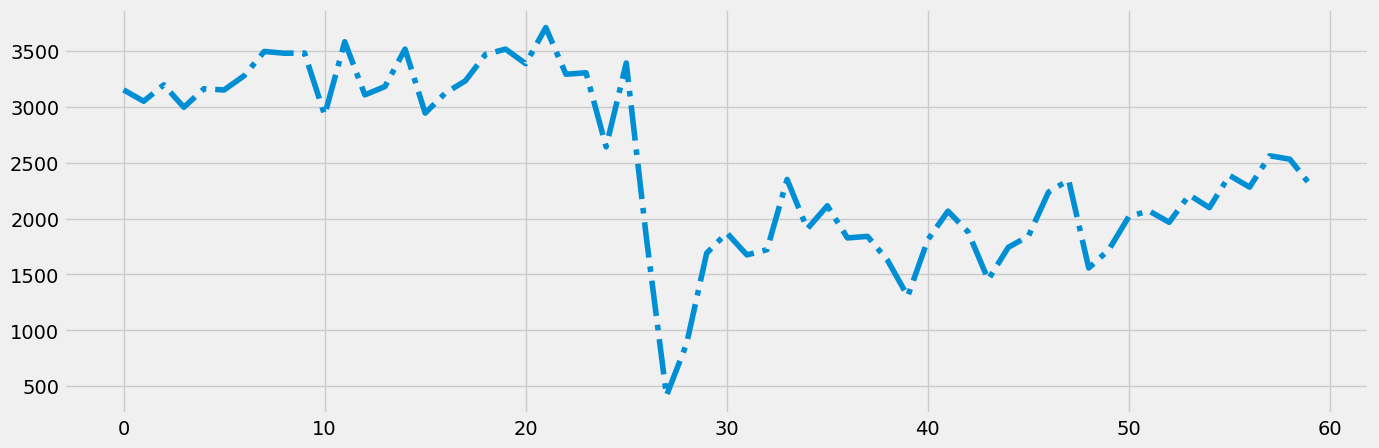

In [13]:
df_month[DEPENDENT_VARIABLE].plot(style='-.',figsize=(15, 5))
plt.show()


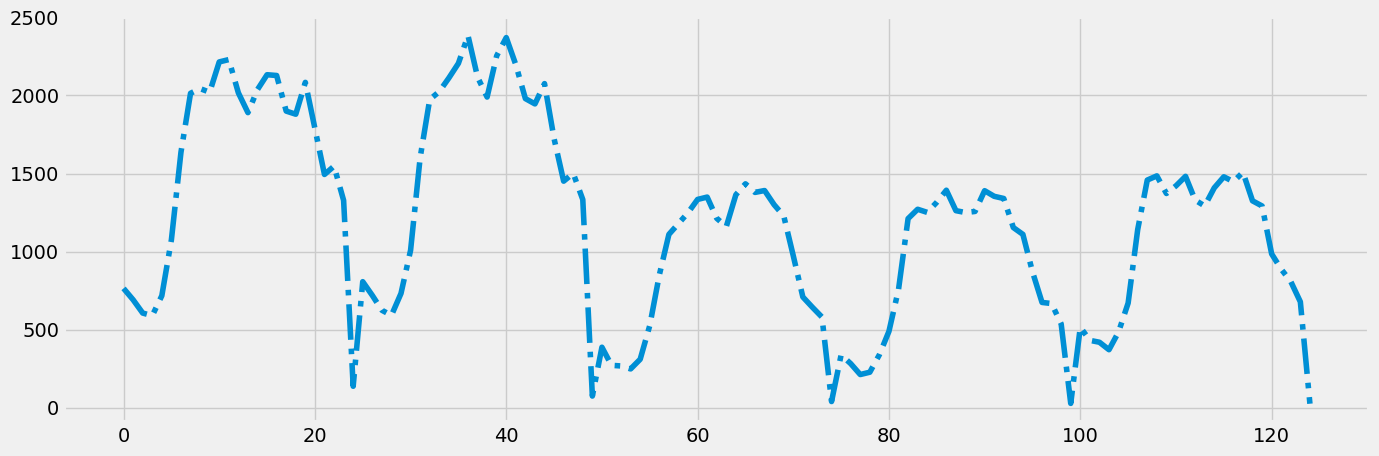

In [14]:
df_hour[DEPENDENT_VARIABLE].plot(style='-.', figsize=(15, 5),)
plt.show()

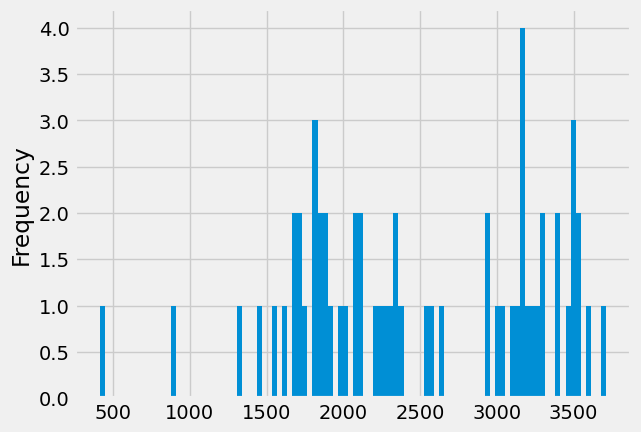

In [15]:
df_month[DEPENDENT_VARIABLE].plot(kind='hist', bins=100);

<Axes: ylabel='Frequency'>

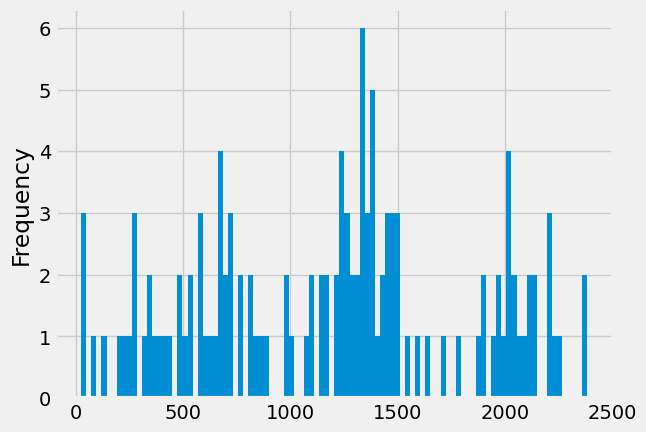

In [16]:
df_hour[DEPENDENT_VARIABLE].plot(kind='hist', bins=100)


In [85]:
from dateutil.relativedelta import relativedelta, MO
dtime_day = {
    "00:00-00:59": "Night",
    "01:00-01:59": "Night",
    "02:00-02:59": "Night",
    "03:00-03:59": "Night",
    "04:00-04:59": "Night",
    "05:00-05:59": "Morning",
    "06:00-06:59": "Morning",
    "07:00-07:59": "Morning",
    "08:00-08:59": "Morning",
    "09:00-09:59": "Morning",
    "10:00-10:59": "Morning",
    "11:00-11:59": "Morning",
    "12:00-12:59": "Afternoon",
    "13:00-13:59": "Afternoon",
    "14:00-14:59": "Afternoon",
    "15:00-15:59": "Afternoon",
    "16:00-16:59": "Afternoon",
    "17:00-17:59": "Afternoon",
    "18:00-18:59": "Evening",
    "19:00-19:59": "Evening",
    "20:00-20:59": "Night",
    "21:00-21:59": "Night",
    "22:00-22:59": "Night",
    "23:00-23:59": "Night",
    "Time Not Stated": "unkown",
}

# 0 - Not rush hour
# 1 - Rush hour
'''
Worst traffic is at 7AM to 9AM and on 5PM to 9PM
Medium traffic is at 9AM to 10AM and on 9PM to 11PM
Low Traffic rest of the Hour
'''
rush_hour = {
    "00:00-00:59":  "Low",
    "01:00-01:59":  "Low",
    "02:00-02:59": "Low",
    "03:00-03:59": "Low",
    "04:00-04:59": "Low",
    "05:00-05:59": "Low",
    "06:00-06:59": "Low",
    "07:00-07:59": "High",
    "08:00-08:59": "High",
    "09:00-09:59": "Medium",
    "10:00-10:59": "Low",
    "11:00-11:59": "Low",
    "12:00-12:59": "Low",
    "13:00-13:59": "Low",
    "14:00-14:59": "Low",
    "15:00-15:59": "Low",
    "16:00-16:59": "Low",
    "17:00-17:59": "High",
    "18:00-18:59": "High",
    "19:00-19:59": "High",
    "20:00-20:59": "High",
    "21:00-21:59": "Medium",
    "22:00-22:59": "Medium",
    "23:00-23:59": "Medium",
    "Time Not Stated": "Neutral",
}


def create_features_monthly(df, target_variable):
    df['Year'] = df['Year'].apply(lambda x: int(x))
    X = df[[
        'Year', 'Month', DEPENDENT_VARIABLE
    ]]
    X = pd.get_dummies(X, columns=['Month'])
    if target_variable:
        y = df[target_variable]
        return X, y
    return X


def create_features_hourly(df, target_variable):
    def hourmin_decimal(time, index):
        if time == 'Time Not Stated':
            return -1
        time = time.split('-')[index].split(':')
        hour = int(time[0])
        minutes = int(time[-1])
        return int(hour) * 3600 + int(minutes) * 60

    df['Year'] = df['Year'].apply(lambda x: int(x))
    df['Day Time'] = df['Time Hour'].apply(lambda x:  dtime_day[x])
    df['Hour Start'] = df['Time Hour'].apply(lambda x: hourmin_decimal(x, 0))
    df['Hour End'] = df['Time Hour'].apply(lambda x: hourmin_decimal(x, -1))
    df['Traffic'] = df['Time Hour'].apply(lambda x: rush_hour[x])
    X = df[[
        'Year', 'Day Time', 'Hour Start', 'Hour End', 'Traffic', DEPENDENT_VARIABLE
    ]]
    X = pd.get_dummies(X, columns=['Day Time', 'Traffic'])
    if target_variable:
        y = df[target_variable]
        return X, y
    return X


def mean_absolute_percentage_error_func(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        Mean absolute percentage error 
    '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    return mape


def timeseries_evaluation_metrics_func(y_true, y_pred):
    '''
    Calculate the following evaluation metrics:
        - MSE
        - MAE
        - RMSE
        - MAPE
        - R²
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        MSE, MAE, RMSE, MAPE and R² 
    '''
    # print('Evaluation metric results: ')
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error_func(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    return {"mse": mse, "mae": mae, "rmse": rmse, "mape": mape, "r2": r2}, [mse, mae, rmse, mape, r2 ]


def dataframe_splitter(arr, indexes_range):
    result = [[] for i in range(indexes_range)]
    for i in range(indexes_range):
        result[i] = [j[i] for j in arr]
    return result


def time_series_split(data_frame, target_column_name, n_splits=5):
    X = data_frame.drop(target_column_name, axis=1)
    y = data_frame[target_column_name]

    tscv = TimeSeriesSplit(n_splits=n_splits)
    train_test_sets = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        train_test_sets.append((X_train, y_train, X_test, y_test))

    return train_test_sets


def time_based_split(data, train_pct):
    train_size = int(len(data) * train_pct)
    train, test = data[:train_size], data[train_size:]
    return train, test

def print_values_metrics(model_name, metric_dict):
  printed_metrics = ''.join(
      [f' ({i}: {round(metric_dict[i], 4):,})\t' for i in metric_dict])
  print(f"{printed_metrics}: {model_name}")


In [186]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge,
                                  OrthogonalMatchingPursuit, ARDRegression, LogisticRegression,
                                  PoissonRegressor, GammaRegressor, TweedieRegressor, PassiveAggressiveRegressor,
                                  RANSACRegressor, TheilSenRegressor, HuberRegressor)



from sklearn.svm import (SVR, NuSVR, LinearSVR)
from sklearn.tree import (DecisionTreeRegressor)
from sklearn.ensemble import (ExtraTreesRegressor, AdaBoostRegressor,
                              GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor)
from sklearn.neighbors import (RadiusNeighborsRegressor)
from sklearn.neural_network import (MLPRegressor)
from sklearn.gaussian_process import (GaussianProcessRegressor)
from xgboost import XGBRegressor, XGBRFRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

# LSTM custom
# LSTM + Transfer Learning


include_params = True

def linear_regression(trainX, trainY, testX):
    param_grid = {
        'fit_intercept': [True, False],
    }
    model = LinearRegression()
    model = GridSearchCV(model, param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def ridge(trainX, trainY, testX):
    param_grid = {
        'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0], 
        "fit_intercept": [True, False], 
        "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    }
    model = Ridge()
    model = GridSearchCV(model, param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def lasso(trainX, trainY, testX):
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
        'max_iter': [500, 1000, 2000, 5000],
        'tol': [1e-5, 1e-4, 1e-3],
        'warm_start': [True, False],
        'positive': [True, False],
    }
    model = Lasso()
    model = GridSearchCV(model, param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def elastic_net(trainX, trainY, testX):
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'fit_intercept': [True, False],
        'max_iter': [500, 1000, 2000, 5000],
        'tol': [1e-5, 1e-4, 1e-3],
        'warm_start': [True, False],
        'positive': [True, False],
    }
    model = ElasticNet()
    model = GridSearchCV(model, param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def bayesian_ridge(trainX, trainY, testX):
    param_grid = {
        'alpha_1': [1e-6, 1e-5, 1e-4, 1e-3],
        'alpha_2': [1e-6, 1e-5, 1e-4, 1e-3],
        'lambda_1': [1e-6, 1e-5, 1e-4, 1e-3],
        'lambda_2': [1e-6, 1e-5, 1e-4, 1e-3],
        'fit_intercept': [True, False],
        'tol': [1e-5, 1e-4, 1e-3]
    }
    model = BayesianRidge()
    model = GridSearchCV(model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def orthogonal_matching_pursuit(trainX, trainY, testX):
    param_grid = {
        'n_nonzero_coefs': list(range(1, trainX.shape[1] + 1)),
        'fit_intercept': [True, False]
    }
    model = OrthogonalMatchingPursuit()
    model = GridSearchCV(model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def ard_regression(trainX, trainY, testX):
    param_grid = {
        'alpha_1': [1e-6, 1e-5, 1e-4, 1e-3],
        'alpha_2': [1e-6, 1e-5, 1e-4, 1e-3],
        'lambda_1': [1e-6, 1e-5, 1e-4, 1e-3],
        'lambda_2': [1e-6, 1e-5, 1e-4, 1e-3],
        'fit_intercept': [True, False],
        'tol': [1e-5, 1e-4, 1e-3]
    }
    model = ARDRegression()
    model = GridSearchCV(model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def logistic_regression(trainX, trainY, testX):
    param_grid = {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [50, 100, 200, 500],
        'tol': [1e-5, 1e-4, 1e-3]
    }
    model = LogisticRegression()

    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=KFold(n_splits=5))
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def poisson_regressor(trainX, trainY, testX):
    param_grid = {
        'alpha': [0.0, 0.001, 0.01, 0.1, 1, 10],
        'fit_intercept': [True, False],
        'max_iter': [50, 100, 200, 500],
        'tol': [1e-5, 1e-4, 1e-3],
        'warm_start': [True, False]
    }
    model = PoissonRegressor()

    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def gamma_regressor(trainX, trainY, testX):
    param_grid = {
        'alpha': [0.0, 0.001, 0.01, 0.1, 1, 10],
        'fit_intercept': [True, False],
        'max_iter': [50, 100, 200, 500],
        'tol': [1e-5, 1e-4, 1e-3],
        'warm_start': [True, False]
    }
    model = GammaRegressor()

    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def tweedie_regressor(trainX, trainY, testX):
    param_grid = {
        'alpha': [0.0, 0.001, 0.01, 0.1, 1, 10],
        'power': [0, 1, 1.5, 2, 3],
        'fit_intercept': [True, False],
        'max_iter': [50, 100, 200, 500],
        'tol': [1e-5, 1e-4, 1e-3],
        'warm_start': [True, False]
    }
    model = TweedieRegressor()

    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def passive_aggressive_regressor(trainX, trainY, testX):
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
        'max_iter': [50, 100, 200, 500],
        'tol': [1e-5, 1e-4, 1e-3],
        'early_stopping': [True, False],
        'validation_fraction': [0.1, 0.2, 0.3],
        'n_iter_no_change': [5, 10, 15],
        'shuffle': [True, False],
        'warm_start': [True, False]
    }
    model = PassiveAggressiveRegressor()

    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def ransac_regressor(trainX, trainY, testX):
    param_grid = {
        'min_samples': [0.1, 0.2, 0.3, 0.4, 0.5],
        'residual_threshold': [1, 5, 10, 20],
        'max_trials': [100, 500, 1000],
        'stop_n_inliers': [50, 100, 200],
        'stop_score': [0.9, 0.95, 0.99],
        'stop_probability': [0.9, 0.95, 0.99],
        'loss': ['squared_error', 'absolute_error']
    }
    model = RANSACRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def theil_sen_regressor(trainX, trainY, testX):
    param_grid = {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'max_subpopulation': [1e4, 1e5, 1e6],
        'n_subsamples': [None, 50, 100, 200],
        'max_iter': [50, 100, 200, 500],
        'tol': [1e-5, 1e-4, 1e-3],
    }
    model = TheilSenRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def huber_regressor(trainX, trainY, testX):
    param_grid = {
        'epsilon': [1.0, 1.5, 2.0],
        'fit_intercept': [True, False],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'max_iter': [50, 100, 200, 500],
        'tol': [1e-5, 1e-4, 1e-3],
        'warm_start': [True, False]
    }
    model = HuberRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def svr(trainX, trainY, testX):
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1, 10],
        'coef0': [-1, 0, 1],
        'shrinking': [True, False],
        'tol': [1e-5, 1e-4, 1e-3],
    }
    model = SVR()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour
    
def nu_svr(trainX, trainY, testX):
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1, 10],
        'coef0': [-1, 0, 1],
        'nu': [0.1, 0.3, 0.5, 0.7, 0.9],
        'shrinking': [True, False],
        'tol': [1e-5, 1e-4, 1e-3],
    }
    model = NuSVR()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def linear_svr(trainX, trainY, testX):
    param_grid = {
        'epsilon': [0.01, 0.1, 1, 10],
        'C': [0.01, 0.1, 1, 10, 100],
        'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
        'fit_intercept': [True, False],
        'intercept_scaling': [1, 2, 3],
        'dual': [True, False],
        'tol': [1e-5, 1e-4, 1e-3],
        'max_iter': [50, 100, 200, 500],
    }
    model = LinearSVR()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def decision_tree_regressor(trainX, trainY, testX):
    param_grid = {
        'criterion': ['mse', 'friedman_mse', 'mae'],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_leaf_nodes': [None, 5, 10, 15],
        'min_impurity_decrease': [0.0, 0.1, 0.2],
    }
    model = DecisionTreeRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def extra_trees_regressor(trainX, trainY, testX):
    param_grid = {
        'n_estimators': [50, 100, 200, 500],
        'criterion': ['mse', 'mae', 'friedman_mse', 'poisson'],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_leaf_nodes': [None, 5, 10, 15],
        'min_impurity_decrease': [0.0, 0.1, 0.2],
    }
    model = ExtraTreesRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def ada_boost_regressor(trainX, trainY, testX):
    param_grid = {
        'base_estimator': [DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=5)],
        'n_estimators': [50, 100, 200, 500],
        'learning_rate': [0.01, 0.1, 1, 10],
        'loss': ['linear', 'square', 'exponential']
    }
    model = AdaBoostRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def gradient_boosting_regressor(trainX, trainY, testX):
    param_grid = {
        'n_estimators': [50, 100, 200, 500],
        'learning_rate': [0.01, 0.1, 1, 10],
        'max_depth': [3, 5, 7, 9],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_leaf_nodes': [None, 5, 10, 15],
        'min_impurity_decrease': [0.0, 0.1, 0.2],
        'subsample': [0.5, 0.75, 1.0],
    }
    model = GradientBoostingRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def hist_gradient_boosting_regressor(trainX, trainY, testX):
    param_grid = {
        'learning_rate': [0.01, 0.1, 1, 10],
        'max_iter': [50, 100, 200, 500],
        'max_depth': [3, 5, 7, 9],
        'max_leaf_nodes': [None, 5, 10, 15],
        'min_samples_leaf': [1, 2, 5, 10],
        'l2_regularization': [0.0, 0.1, 0.2],
        'max_bins': [255, 512, 1024],
        'warm_start': [True, False],
        'early_stopping': [None, 'auto', 10],
    }
    model = HistGradientBoostingRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def random_forest_regressor(trainX, trainY, testX):
    param_grid = {
        'n_estimators': [50, 100, 200, 500],
        'criterion': ['mse', 'mae'],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_leaf_nodes': [None, 5, 10, 15],
        'min_impurity_decrease': [0.0, 0.1, 0.2],
        'bootstrap': [True, False],
        'oob_score': [True, False],
    }
    model = RandomForestRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def radius_neighbors_regressor(trainX, trainY, testX):
    param_grid = {
        'radius': [1.0, 2.0, 3.0, 4.0],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [10, 20, 30, 40]
    }
    model = RadiusNeighborsRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def mlp_regressor(trainX, trainY, testX):
    param_grid = {
        'hidden_layer_sizes': [(10,), (20,), (30,), (50,)],
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'batch_size': ['auto', 32, 64, 128],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'learning_rate_init': [0.001, 0.01, 0.1],
        'max_iter': [50, 100, 200, 500],
        'shuffle': [True, False],
        'tol': [1e-4, 1e-3, 1e-2],
        'early_stopping': [True, False],
        'validation_fraction': [0.1, 0.2, 0.3],
        'beta_1': [0.9, 0.95, 0.99],
        'beta_2': [0.999, 0.9999],
        'epsilon': [1e-8, 1e-9, 1e-10]
    }
    model = MLPRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def gaussian_process_regressor(trainX, trainY, testX):
    param_grid = {
        'kernel': [RBF(length_scale=1.0), Matern(length_scale=1.0)],
        'alpha': [1e-10, 1e-5, 1e-3, 1e-1],
        'optimizer': ['fmin_l_bfgs_b', 'diff_evo'],
        'n_restarts_optimizer': [0, 1, 2],

    }
    model = GaussianProcessRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def xgb_regressor(trainX, trainY, testX):
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.5],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'subsample': [0.5, 0.7, 0.9],
        'colsample_bytree': [0.5, 0.7, 0.9],
        'gamma': [0.0, 0.1, 0.2],
        'reg_alpha': [0.0, 0.1, 0.5],
        'reg_lambda': [0.0, 0.1, 0.5],
        'min_child_weight': [1, 3, 5],
        'objective': ['reg:squarederror', 'reg:pseudohubererror'],
        'booster': ['gbtree', 'dart'],
    }
    model = XGBRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour


def xgbrf_regressor(trainX, trainY, testX):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'subsample': [0.5, 0.7, 0.9],
        'colsample_bynode': [0.5, 0.7, 0.9],
        'colsample_bytree': [0.5, 0.7, 0.9],
        'gamma': [0.0, 0.1, 0.2],
        'reg_alpha': [0.0, 0.1, 0.5],
        'reg_lambda': [0.0, 0.1, 0.5],
        'min_child_weight': [1, 3, 5],
    }
    model = XGBRFRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour


def sarimax_forecast(trainX, trainY, testX):
    # Combine trainX and trainY into a single DataFrame
    train = trainX.copy()
    Ytrain = trainY.copy()
    Xtest = testX.copy()
    train[DEPENDENT_VARIABLE] = Ytrain

    # Create 'DateTime' index using 'Year' and 'Hour Start' columns
    train['DateTime'] = train.apply(lambda row: pd.Timestamp(year=int(
        row['Year']), month=1, day=1) + pd.Timedelta(hours=int(row['Hour Start'])), axis=1)
    train = train.set_index('DateTime')
    Xtest['DateTime'] = Xtest.apply(lambda row: pd.Timestamp(year=int(
        row['Year']), month=1, day=1) + pd.Timedelta(hours=int(row['Hour Start'])), axis=1)
    Xtest = Xtest.set_index('DateTime')

    # Convert boolean columns to integers
    bool_columns = ['Day Time_Afternoon', 'Day Time_Evening', 'Day Time_Morning',
                    'Day Time_Night', 'Day Time_unkown', 'Traffic_High', 'Traffic_Low',
                    'Traffic_Medium', 'Traffic_Neutral']

    train[bool_columns] = train[bool_columns].astype(int)
    Xtest[bool_columns] = Xtest[bool_columns].astype(int)

    # Fit the SARIMAX model (you might need to adjust the order and seasonal_order parameters)
    model = SARIMAX(train[DEPENDENT_VARIABLE],
                    exog=train[bool_columns],
                    order=(1, 1, 1),
                    seasonal_order=(1, 1, 1, 24))
    results = model.fit()

   # Forecast the dependent variable for testX
    forecast = results.predict(start=len(train),
                               end=len(train) + len(Xtest) - 1,
                               exog=Xtest[bool_columns])

    # Reset the index of the forecast to match the testX dataset
    forecast.index = Xtest.index

    return forecast


In [188]:
include_params = True

# ----------- Hour -----------
df_hour_X = df_hour.copy()
# Create hourly features
df_hour_feature = create_features_hourly(df_hour_X, target_variable='')
train_test_hour = time_series_split(
    df_hour_feature, DEPENDENT_VARIABLE, 5)

# ----------- Monthly -----------
df_month_X = df_month.copy()
# Create monthly features
df_month_feature = create_features_monthly(
    df_month_X, target_variable='')
train_test_month = time_series_split(
    df_month_feature, DEPENDENT_VARIABLE, 5)

def result_mode(dataset, name):
  # Initial 
  print(f"START : {'-'*20}{name}{'-'*20} \n\n")
  index = ['mse', 'mae', 'rmse', 'mape', 'r2']
  best_value = {i: float('inf') for i in index}
  best_model = {i: '' for i in index}

  for i, (X_train, y_train, X_test, y_test) in enumerate(dataset):
      print(f"Train-test set {i + 1} : {'-'*70}")
      columns = []
      data = []
      data_dict  = []

      # ============================================================================================================
     

      model_name = 'XGBRFRegressor'
      regression_pred = xgbrf_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'XGBRegressor'
      regression_pred = xgb_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)
      
      model_name = 'GaussianProcessRegressor'
      regression_pred = gaussian_process_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'MLPRegressor'
      regression_pred = mlp_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'RadiusNeighborsRegressor'
      regression_pred = radius_neighbors_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'RandomForestRegressor'
      regression_pred = random_forest_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)
  
      model_name = 'HistGradientBoostingRegressor'
      regression_pred = hist_gradient_boosting_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'GradientBoostingRegressor'
      regression_pred = gradient_boosting_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'AdaBoostRegressor'
      regression_pred = ada_boost_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'ExtraTreesRegressor'
      regression_pred = extra_trees_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'DecisionTreeRegressor'
      regression_pred = decision_tree_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'LinearSVR'
      regression_pred = linear_svr(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'LinearRegression'
      regression_pred = linear_regression(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'Ridge'
      regression_pred = ridge(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'Lasso'
      regression_pred = lasso(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'BayesianRidge'
      regression_pred = bayesian_ridge(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'OrthogonalMatchingPursuit'
      regression_pred = orthogonal_matching_pursuit(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'ARDRegression'
      regression_pred = ard_regression(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'LogisticRegression'
      regression_pred = logistic_regression(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'GammaRegressor'
      regression_pred = gamma_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'TweedieRegressor'
      regression_pred = tweedie_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'PassiveAggressiveRegressor'
      regression_pred = passive_aggressive_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'RANSACRegressor'
      regression_pred = ransac_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)
      
      model_name = 'TheilSenRegressor'
      regression_pred = theil_sen_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'HuberRegressor'
      regression_pred = huber_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)
      
      model_name = 'SARIMAX'
      regression_pred = sarimax_forecast(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)
      # ============================================================================================================
      # Finding best 
      for model_name, performance in zip(columns, data_dict):
        for perf in performance:
          if performance[perf] < best_value[perf]:
            best_value[perf] = performance[perf] 
            best_model[perf] = model_name

      # Save from dataframe
      save_stats_df = pd.DataFrame(data=dataframe_splitter(data, len(index)), index=index, columns=columns)
      save_stats_df.to_csv(f"{name}-Train-test-set_{i + 1}.csv")
      print("\n\n")


  # Print Best model with best value 
  print(f"BEST PERFORMANCE {name}\n")
  result = ('\n'.join([f'+ {i.upper()} : {best_model[i]} = {best_value[i]}' for i in index]))
  print(result)
  print("\n\n")
  print(f"END : {'-'*20}{name}{'-'*20}")
  return result

hourly_res = result_mode(train_test_hour, 'hourly')



START : --------------------hourly-------------------- 


Train-test set 1 : ----------------------------------------------------------------------
 (mse: 14,278.5437)	 (mae: 90.4584)	 (rmse: 119.4929)	 (mape: 0.059)	 (r2: 0.9651)	: XGBRFRegressor
 (mse: 9,101.1379)	 (mae: 69.9501)	 (rmse: 95.3999)	 (mape: 0.0389)	 (r2: 0.9778)	: XGBRegressor
 (mse: 560,672.6725)	 (mae: 694.9215)	 (rmse: 748.7808)	 (mape: 0.4094)	 (r2: -0.3697)	: GaussianProcessRegressor
 (mse: 3,011,166.8809)	 (mae: 1,465.0659)	 (rmse: 1,735.2714)	 (mape: 0.9094)	 (r2: -6.3562)	: MLPRegressor
 (mse: 9,101.05)	 (mae: 69.95)	 (rmse: 95.3994)	 (mape: 0.0389)	 (r2: 0.9778)	: RadiusNeighborsRegressor
 (mse: 11,520.6877)	 (mae: 76.7585)	 (rmse: 107.3345)	 (mape: 0.0445)	 (r2: 0.9719)	: RandomForestRegressor
 (mse: 425,482.4724)	 (mae: 614.178)	 (rmse: 652.2902)	 (mape: 0.5181)	 (r2: -0.0394)	: HistGradientBoostingRegressor
 (mse: 9,350.4388)	 (mae: 70.1235)	 (rmse: 96.6977)	 (mape: 0.0394)	 (r2: 0.9772)	: GradientBoostingRe

 This problem is unconstrained.


 (mse: 393,338.9638)	 (mae: 533.7332)	 (rmse: 627.1674)	 (mape: 0.8549)	 (r2: -0.5242)	: XGBRFRegressor
 (mse: 398,112.883)	 (mae: 532.8725)	 (rmse: 630.9619)	 (mape: 0.7924)	 (r2: -0.5427)	: XGBRegressor
 (mse: 88,672.5654)	 (mae: 225.534)	 (rmse: 297.7794)	 (mape: 0.2012)	 (r2: 0.6564)	: GaussianProcessRegressor
 (mse: 121,575.0885)	 (mae: 272.5596)	 (rmse: 348.6762)	 (mape: 0.4657)	 (r2: 0.5289)	: MLPRegressor
 (mse: 397,377.05)	 (mae: 527.55)	 (rmse: 630.3785)	 (mape: 0.7648)	 (r2: -0.5399)	: RadiusNeighborsRegressor
 (mse: 390,331.7728)	 (mae: 541.5285)	 (rmse: 624.7654)	 (mape: 0.9221)	 (r2: -0.5126)	: RandomForestRegressor
 (mse: 573,314.6745)	 (mae: 684.6169)	 (rmse: 757.1755)	 (mape: 1.9762)	 (r2: -1.2217)	: HistGradientBoostingRegressor
 (mse: 399,734.7351)	 (mae: 548.1805)	 (rmse: 632.2458)	 (mape: 0.8075)	 (r2: -0.549)	: GradientBoostingRegressor
 (mse: 431,097.2321)	 (mae: 566.102)	 (rmse: 656.58)	 (mape: 0.8083)	 (r2: -0.6706)	: AdaBoostRegressor
 (mse: 397,377.05)	 (mae:

 This problem is unconstrained.



At iterate    5    f=  2.97512D+00    |proj g|=  1.87401D-02

At iterate   10    f=  2.97023D+00    |proj g|=  2.97963D-03

At iterate   15    f=  2.96974D+00    |proj g|=  1.13661D-03

At iterate   20    f=  2.96125D+00    |proj g|=  7.09011D-03

At iterate   25    f=  2.95595D+00    |proj g|=  8.47815D-03

At iterate   30    f=  2.95366D+00    |proj g|=  4.94191D-03

At iterate   35    f=  2.95312D+00    |proj g|=  7.34989D-03

At iterate   40    f=  2.95285D+00    |proj g|=  1.94419D-03

At iterate   45    f=  2.95267D+00    |proj g|=  1.82247D-03

At iterate   50    f=  2.95255D+00    |proj g|=  4.36045D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.10666D+00    |proj g|=  2.48195D-02

At iterate   10    f=  4.10240D+00    |proj g|=  7.82497D-04

At iterate   15    f=  4.08125D+00    |proj g|=  4.15025D-02

At iterate   20    f=  4.07262D+00    |proj g|=  1.51758D-02

At iterate   25    f=  4.07075D+00    |proj g|=  5.82032D-04

At iterate   30    f=  4.07001D+00    |proj g|=  1.73051D-02

At iterate   35    f=  4.06679D+00    |proj g|=  3.02678D-03

At iterate   40    f=  4.06663D+00    |proj g|=  1.15705D-03

At iterate   45    f=  4.06213D+00    |proj g|=  1.06053D-02

At iterate   50    f=  4.05817D+00    |proj g|=  2.91591D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.75767D+00    |proj g|=  7.98439D-03

At iterate   10    f=  4.75740D+00    |proj g|=  8.30854D-04

At iterate   15    f=  4.75533D+00    |proj g|=  1.75188D-02

At iterate   20    f=  4.73728D+00    |proj g|=  4.10369D-03

At iterate   25    f=  4.73608D+00    |proj g|=  3.55590D-03

At iterate   30    f=  4.73584D+00    |proj g|=  1.69983D-03

At iterate   35    f=  4.73573D+00    |proj g|=  1.48772D-03

At iterate   40    f=  4.73564D+00    |proj g|=  1.86433D-03

At iterate   45    f=  4.73530D+00    |proj g|=  3.04224D-04

At iterate   50    f=  4.73530D+00    |proj g|=  2.16068D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.10732D+00    |proj g|=  5.31104D-02

At iterate   10    f=  5.09627D+00    |proj g|=  4.80656D-03

At iterate   15    f=  5.09579D+00    |proj g|=  9.46661D-03

At iterate   20    f=  5.07594D+00    |proj g|=  8.39659D-03

At iterate   25    f=  5.07354D+00    |proj g|=  2.24116D-03

At iterate   30    f=  5.07335D+00    |proj g|=  1.25239D-03

At iterate   35    f=  5.07327D+00    |proj g|=  1.02044D-03

At iterate   40    f=  5.07318D+00    |proj g|=  1.62726D-03

At iterate   45    f=  5.07251D+00    |proj g|=  3.75682D-03

At iterate   50    f=  5.07237D+00    |proj g|=  3.19909D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [45]:
print(hourly_res)


+ MSE : ExtraTreesRegressor = 9101.05
+ MAE : ExtraTreesRegressor = 69.95
+ RMSE : ExtraTreesRegressor = 95.39942347834183
+ MAPE : ExtraTreesRegressor = 0.038920775712973546
+ R2 : TheilSenRegressor = -91970.79243848778
